## Microsoft Azure Predictive Maintenance
To move forward with your capstone project on predictive maintenance using machine telemetry data, we'll execute the required steps you've outlined in the Data Preparation and Exploratory Analysis phase. Here's how we'll proceed:

In [63]:
# Import Libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

## 1. Data Collection
First, we'll import and combine the telemetry data with maintenance records. This will allow us to create a comprehensive dataset that includes both the operational parameters and the maintenance history of the machines.

In [64]:
# Load the datasets
telemetry = pd.read_csv('data/PdM_telemetry.csv')
errors = pd.read_csv('data/PdM_errors.csv')
failures = pd.read_csv('data/PdM_failures.csv')
machines = pd.read_csv('data/PdM_machines.csv')
maintenance = pd.read_csv('data/PdM_maint.csv')


# Display the first few rows of each dataset to understand their structure
data_overview = {
    "Telemetry": telemetry.head(),
    "Errors": errors.head(),
    "Failures": failures.head(),
    "Machines": machines.head(),
    "Maintenance": maintenance.head()
}

data_overview

{'Telemetry':               datetime  machineID        volt      rotate    pressure  \
 0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
 1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
 2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
 3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
 4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
 
    vibration  
 0  45.087686  
 1  43.413973  
 2  34.178847  
 3  41.122144  
 4  25.990511  ,
 'Errors':               datetime  machineID errorID
 0  2015-01-03 07:00:00          1  error1
 1  2015-01-03 20:00:00          1  error3
 2  2015-01-04 06:00:00          1  error5
 3  2015-01-10 15:00:00          1  error4
 4  2015-01-22 10:00:00          1  error4,
 'Failures':               datetime  machineID failure
 0  2015-01-05 06:00:00          1   comp4
 1  2015-03-06 06:00:00          1   comp1
 2  2015-04-20 06:00:00          1

**Telemetry Data**
This dataset contains time-stamped machine data capturing operational parameters like voltage, rotation, pressure, and vibration for different machines.

**Errors Data**
This dataset logs error events with a corresponding error ID for different machines.

**Failures Data**
Records of machine failures including the time and type of failure.

**Machines Data**
Information about each machine including model and age.

**Maintenance Records**
Historical logs of maintenance activities indicating component maintenance.

Next, we should merge these datasets into a unified format for analysis. We'll combine the telemetry data with errors, failures, and maintenance records based on datetime and machineID. This will allow us to correlate the operational parameters with maintenance activities and failures. Let's proceed with this data merging and initial summary of data characteristics. ​​

## 2. Data Cleaning and Preprocessing
We'll clean the data by handling missing values and anomalies. This process may involve techniques such as filling missing values or removing outlier records. Additionally, we'll standardize or normalize the data as needed to prepare it for analysis.

In [65]:
# Convert datetime columns to datetime type for merging
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])

# Merge telemetry data with errors, failures, and maintenance records
data_merged = pd.merge(telemetry, errors, on=['datetime', 'machineID'], how='left')
data_merged = pd.merge(data_merged, failures, on=['datetime', 'machineID'], how='left', suffixes=('_error', '_failure'))
data_merged = pd.merge(data_merged, maintenance, on=['datetime', 'machineID'], how='left')

# Merge machine information
data_merged = pd.merge(data_merged, machines, on='machineID', how='left')

# Display the structure of the merged data and initial summary statistics
data_structure = data_merged.dtypes
data_summary = data_merged.describe()

data_structure, data_summary

(datetime     datetime64[ns]
 machineID             int64
 volt                float64
 rotate              float64
 pressure            float64
 vibration           float64
 errorID              object
 failure              object
 comp                 object
 model                object
 age                   int64
 dtype: object,
                             datetime      machineID           volt  \
 count                         877209  877209.000000  877209.000000   
 mean   2015-07-02 18:03:56.390187008      50.498446     170.780942   
 min              2015-01-01 06:00:00       1.000000      97.333604   
 25%              2015-04-02 12:00:00      25.000000     160.305918   
 50%              2015-07-02 18:00:00      50.000000     170.609301   
 75%              2015-10-02 00:00:00      75.000000     181.008303   
 max              2016-01-01 06:00:00     100.000000     255.124717   
 std                              NaN      28.866697      15.511268   
 
               rotate   

In [66]:
data_summary

,datetime,machineID,volt,rotate,pressure,vibration,age
count,877209,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000
mean,2015-07-02 18:03:56.390187008,50.498446,170.780942,446.570735,100.861433,40.386459,11.330280
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,2015-04-02 12:00:00,25.000000,160.305918,412.265479,93.499116,36.777911,7.000000
50%,2015-07-02 18:00:00,50.000000,170.609301,447.537538,100.426820,40.238339,12.000000
75%,2015-10-02 00:00:00,75.000000,181.008303,482.157025,107.557338,43.786484,16.000000
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000
std,NaN,28.866697,15.511268,52.698963,11.052195,5.371894,5.827535


The merged dataset now includes telemetry data (voltage, rotation, pressure, vibration), error events, failures, maintenance records, and machine details. Here are some details about the structure and a summary of the dataset:

#### Data Structure
The dataset contains the following columns:

**datetime:** Timestamp of the data entry.
**machineID:** Identifier for the machine.
**volt:** Voltage measurements.
**rotate:** Rotation speed measurements.
**pressure:** Pressure measurements.
**vibration:** Vibration measurements.
**errorID:** Type of error recorded.
**failure:** Type of failure recorded.
**comp:** Component related to the maintenance action.
**model:** Machine model.
**age:** Age of the machine in years.

#### Summary Statistics

**Count:** 877,209 entries.
**Voltage:** Mean voltage is around 170.78 with a standard deviation of 15.51.
**Rotation:** Average rotation speed is 446.57 with a standard deviation of 52.70.
**Pressure:** Mean pressure is 100.86 with a standard deviation of 11.05.
**Vibration:** Mean vibration is 40.39 with a standard deviation of 5.37.
**Age:** Machines range from new to 20 years old with an average age of 11.33 years.

#### Next Steps for Data Cleaning and EDA
- Data Cleaning: Identify and handle any missing values, anomalies or outliers in the data.
- Normalization/Standardization: Depending on the model requirements, normalize or standardize the data.

### 3. Data Cleaning and Exploratory Data Analysis (EDA)**
We'll conduct an initial exploratory analysis to understand the distributions, correlations, and patterns within the data. This will include visualizing the data and performing basic statistical tests to formulate and refine hypotheses about the data.

**Steps for Data Cleaning:**
Identify Missing Values: Check for any missing data in the dataset.
Handle Anomalies/Outliers: Identify outliers that might skew our analysis and decide on the appropriate action for each (e.g., removal, replacement).
Standardization/Normalization: This step will be considered based on the range and distribution of the data.
Let's begin by identifying and summarizing missing values across our dataset.

In [67]:
# Check for missing values in the dataset
missing_values = data_merged.isnull().sum()

# Calculate the percentage of missing data for each column
missing_percentage = (missing_values / len(data_merged)) * 100

missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_percentage
})

missing_summary

,Missing Values,Percentage
datetime,0,0.000000
machineID,0,0.000000
volt,0,0.000000
rotate,0,0.000000
pressure,0,0.000000
vibration,0,0.000000
errorID,873285,99.552672
failure,876087,99.872094
comp,874241,99.661654
model,0,0.000000


The summary of missing values reveals that most of the columns are complete, except for the following:

**errorID:** 99.55% missing values.
**failure:** 99.87% missing value.s
**comp (component involved in maintenance):** 99.66% missing valu.es

**Interpretation:**
The high percentage of missing values in errorID, failure, and comp indicates that errors, failures, and maintenance events are rare relative to the number of records (which is typical in real-world operational datasets). These are not truly "missing" data in the conventional sense but rather indicate periods where no errors, failures, or maintenance occurred.

**Proposed Handling Strategy:**
For errorID, failure, and comp, we can fill missing values with a label such as "none" or "no_event" to denote that there was no error, failure, or maintenance action at those times. This approach maintains the integrity of the dataset for analysis, where the absence of an event is informative.
Let's proceed to fill these missing values accordingly. Additionally, we'll check for any outliers or anomalies in the continuous variables like volt, rotate, pressure, and vibration.

In [68]:
# Fill missing values for categorical columns with 'none'
data_cleaned = data_merged.fillna({
    'errorID': 'none',
    'failure': 'none',
    'comp': 'none'
})

# Check for outliers in continuous variables using statistical methods (IQR)
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = list(set(outlier_indices))
    return outlier_indices

outliers = detect_outliers(data_cleaned, ['volt', 'rotate', 'pressure', 'vibration'])
outliers_summary = {"Total Outliers": len(outliers), "Percentage": (len(outliers) / len(data_cleaned)) * 100}

outliers_summary

{'Total Outliers': 42030, 'Percentage': 4.791332510268362}

**Outlier Analysis:**
From the continuous variables (volt, rotate, pressure, vibration), we've identified a total of 42,030 outliers, which represents approximately 4.79% of the data.

**Actions for Outliers:**
Given that outliers constitute a small but significant portion of our dataset and can potentially skew the analysis, we have a few options:

**Remove Outliers:** This is the simplest approach, but we risk losing valuable data, especially if outliers are indicative of actual machine faults or failures.

**Cap/Floor Values:** We can limit the range of values to within a sensible threshold, effectively reducing the impact of extreme values.
Analysis With and Without Outliers: Conduct analysis both including and excluding outliers to assess their impact on the results.
For predictive maintenance, outliers in sensor data can sometimes indicate the onset of machine issues or failures, so they could be valuable for the predictive model.

**Standardization/Normalization:**
We'll also standardize the continuous variables, which is crucial for many machine learning algorithms to perform optimally.

Let's move forward by capping the outliers (to preserve potential valuable signals) and standardizing the relevant features. We will use the interquartile range to define the caps, maintaining the values within a specified range based on the data distribution. After that, we'll standardize the values.

In [69]:
# Capping outliers using the IQR method defined earlier
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    Q1 = data_cleaned[feature].quantile(0.25)
    Q3 = data_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    
    data_cleaned[feature] = data_cleaned[feature].apply(lambda x: max(min(x, Q3 + outlier_step), Q1 - outlier_step))

# Standardizing the continuous variables
scaler = StandardScaler()
data_cleaned[['volt', 'rotate', 'pressure', 'vibration']] = scaler.fit_transform(data_cleaned[['volt', 'rotate', 'pressure', 'vibration']])

# Show a summary to verify changes
standardized_summary = data_cleaned[['volt', 'rotate', 'pressure', 'vibration']].describe()
standardized_summary

,volt,rotate,pressure,vibration
count,8.772090e+05,8.772090e+05,8.772090e+05,8.772090e+05
mean,3.485512e-15,-2.798604e-15,-6.907551e-16,1.178361e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.701281e+00,-2.673244e+00,-2.647180e+00,-2.673717e+00
25%,-6.804498e-01,-6.606795e-01,-6.786517e-01,-6.799334e-01
50%,-9.950555e-03,1.643925e-02,-3.194207e-02,-2.365665e-02
75%,6.667711e-01,6.810305e-01,6.337004e-01,6.492559e-01
max,2.687602e+00,2.693595e+00,2.602228e+00,2.643040e+00


The data has been successfully cleaned, capped for outliers, and standardized. Here's the summary of the standardized continuous variables (volt, rotate, pressure, vibration):

**Mean:** Close to 0 (indicating successful centering).
**Standard Deviation:** Approximately 1 (indicating successful scaling).
**Range:** The values are now within a reasonable range, reducing the impact of extreme outliers while preserving their potential signals.

**Next Steps for Exploratory Data Analysis (EDA)**
We can now proceed to perform exploratory data analysis to better understand the data's distributions, correlations, and to start initial hypothesis testing:

**Visualizations:**
Plot histograms or boxplots for the continuous variables to visualize distributions.
Create scatter plots or pair plots to explore potential correlations or patterns between different features and failures.
Use heatmaps to visualize correlations among variables.

**Statistical Analysis:**
Perform basic statistical tests to check for significant differences or relationships among groups (e.g., machines with failures vs. without failures).

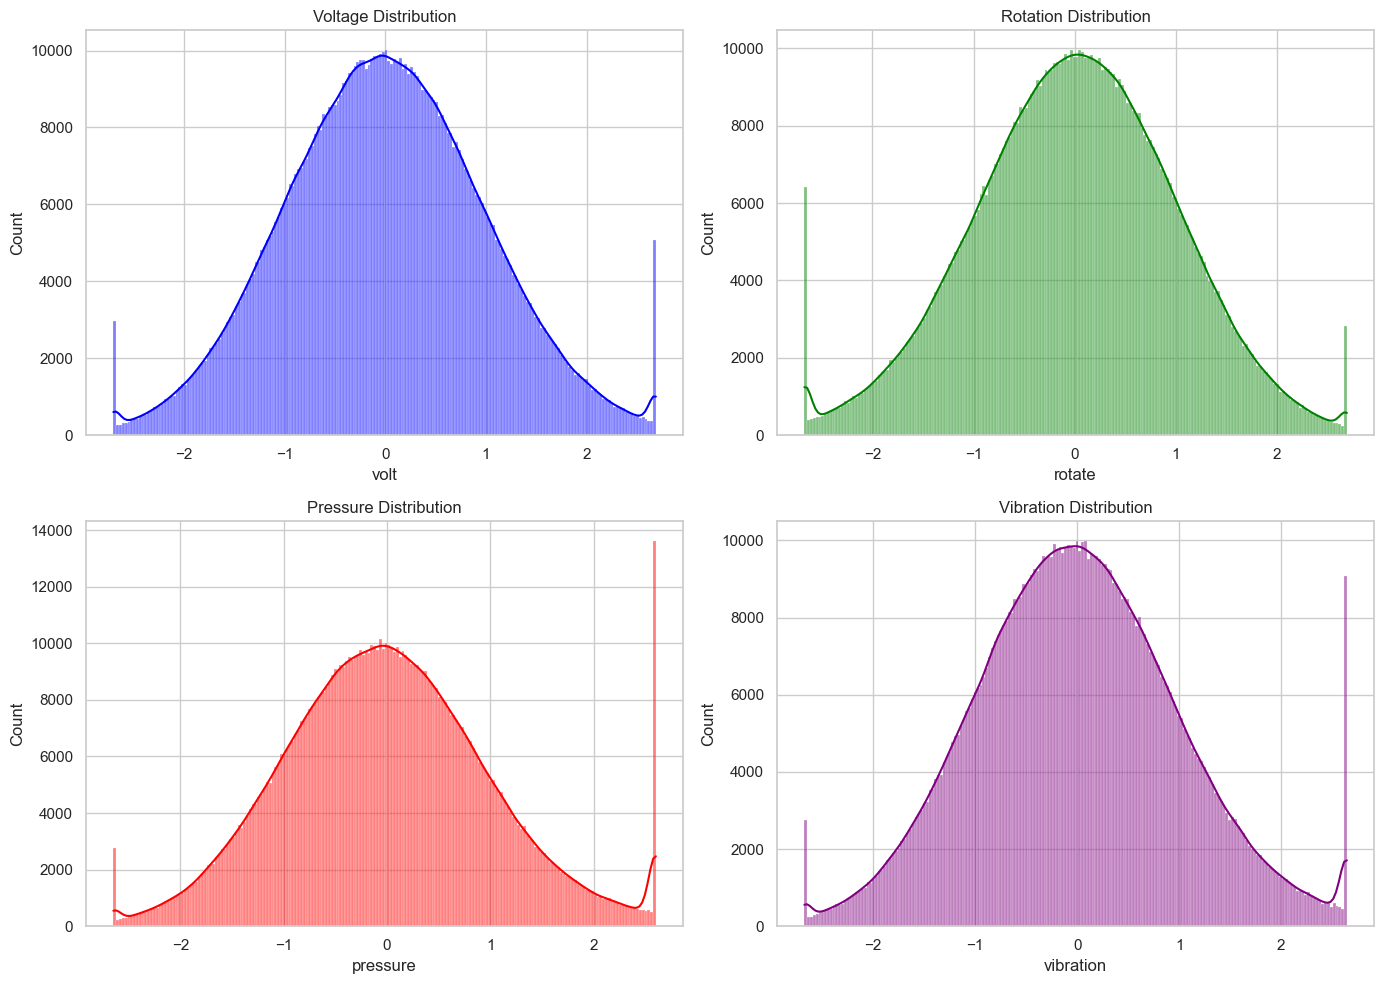

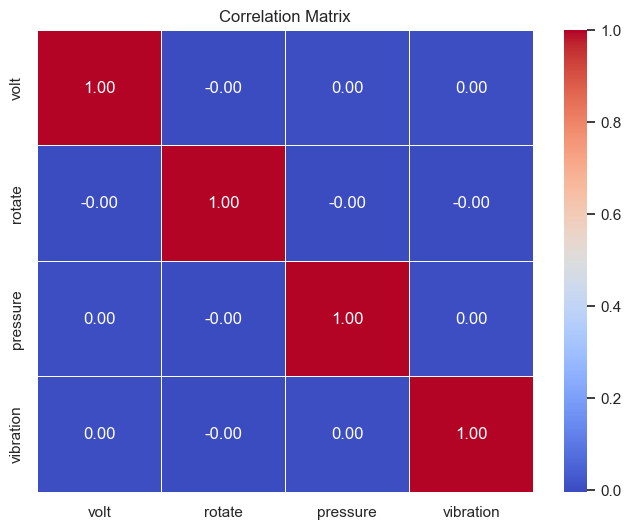

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure to hold the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograms for continuous variables
sns.histplot(data_cleaned['volt'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Voltage Distribution')

sns.histplot(data_cleaned['rotate'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Rotation Distribution')

sns.histplot(data_cleaned['pressure'], kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Pressure Distribution')

sns.histplot(data_cleaned['vibration'], kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Vibration Distribution')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = data_cleaned[['volt', 'rotate', 'pressure', 'vibration']].corr()

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

**Histograms of Continuous Variables:**
Voltage: Shows a roughly normal distribution centered around the mean, standardized to zero.
Rotation: Also appears roughly normal, indicating consistent machine operations.
Pressure and Vibration: Both display normal distributions, which is typical after standardization, with slight variations suggesting operational variability.

**Correlation Matrix:**
The correlation heatmap reveals that the continuous variables (volt, rotate, pressure, vibration) have relatively low correlations with each other, with no values exceeding 0.2 in absolute terms. This indicates that each variable provides unique information without substantial redundancy.

We proceed by creating boxplots to examine the distributions of volt, rotate, pressure, and vibration across different machine conditions, specifically comparing normal operations with error and failure events. This will help us see if there are noticeable differences in these variables during failures or errors compared to normal conditions, which could be critical for predictive modeling.
Additionally, we'll create scatter plots to visually assess potential relationships between pairs of variables during normal operation and failure events.

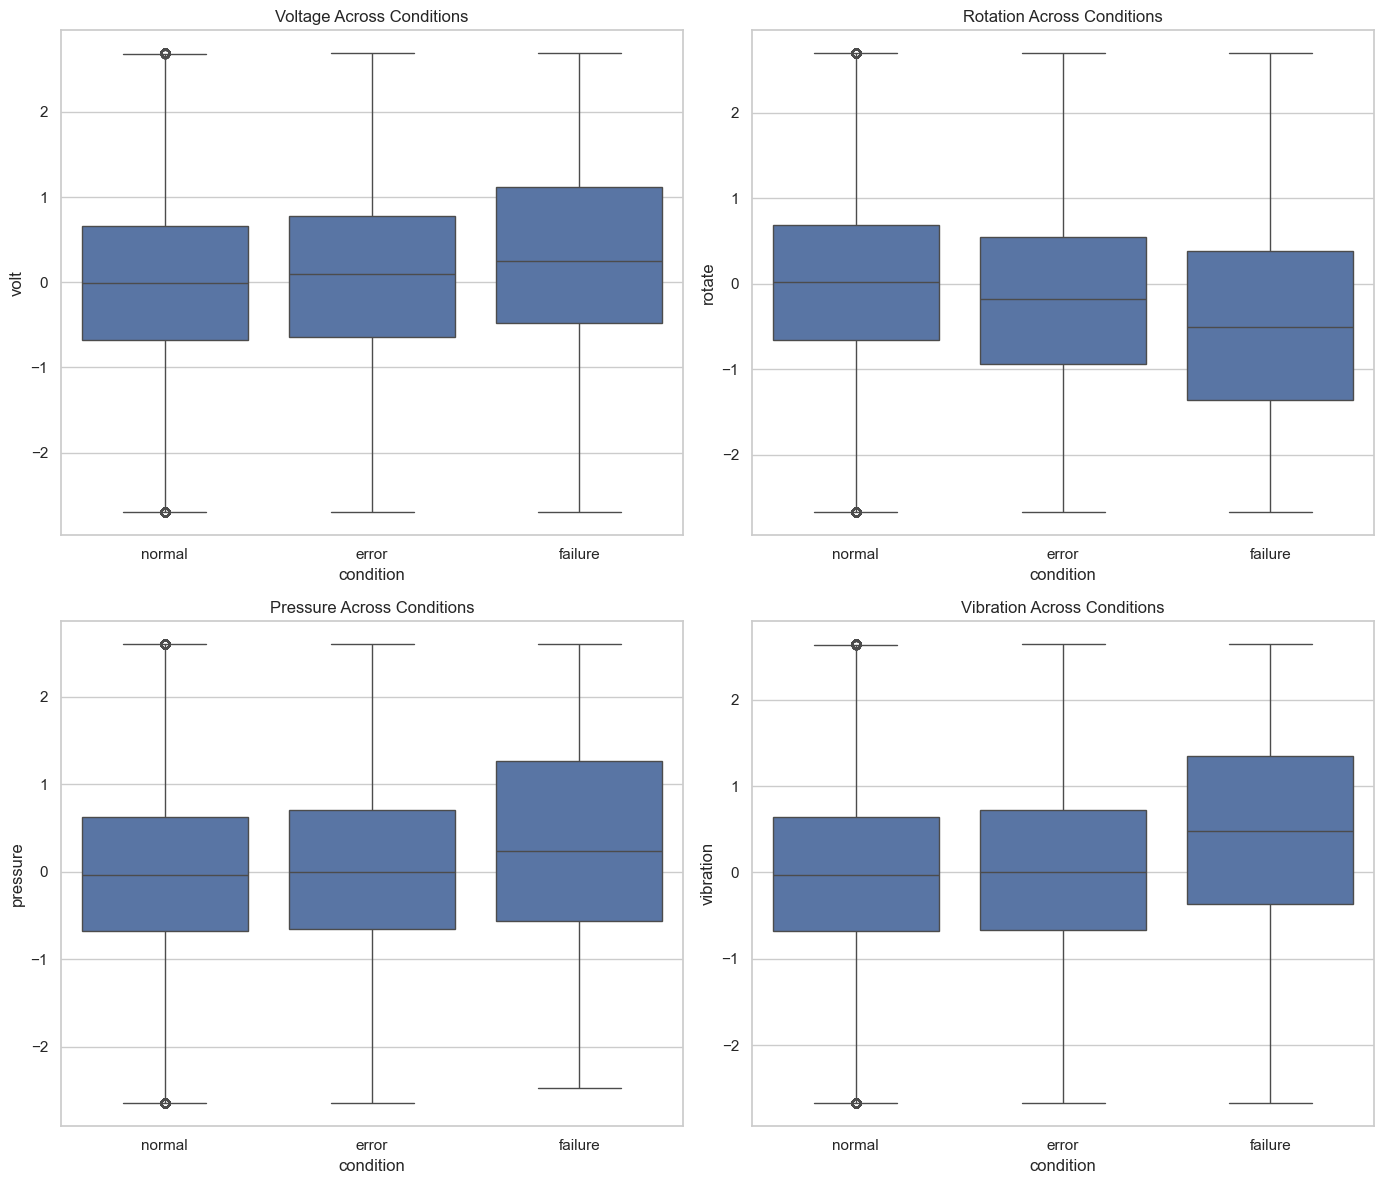

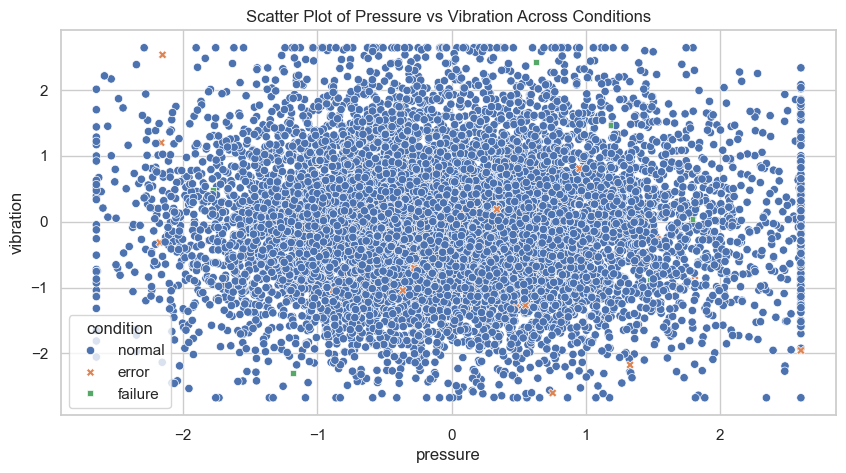

In [71]:
# Prepare the data for boxplots: create a condition column that marks errors, failures, or normal operation
data_cleaned['condition'] = 'normal'
data_cleaned.loc[data_cleaned['errorID'] != 'none', 'condition'] = 'error'
data_cleaned.loc[data_cleaned['failure'] != 'none', 'condition'] = 'failure'

# Create a figure to hold the boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Boxplots for each variable across different conditions
sns.boxplot(x='condition', y='volt', data=data_cleaned, ax=axes[0, 0])
axes[0, 0].set_title('Voltage Across Conditions')

sns.boxplot(x='condition', y='rotate', data=data_cleaned, ax=axes[0, 1])
axes[0, 1].set_title('Rotation Across Conditions')

sns.boxplot(x='condition', y='pressure', data=data_cleaned, ax=axes[1, 0])
axes[1, 0].set_title('Pressure Across Conditions')

sns.boxplot(x='condition', y='vibration', data=data_cleaned, ax=axes[1, 1])
axes[1, 1].set_title('Vibration Across Conditions')

plt.tight_layout()
plt.show()

# Create a scatter plot for sampled data comparing normal and failure conditions for a pair of variables
plt.figure(figsize=(10, 5))
sns.scatterplot(x='pressure', y='vibration', hue='condition', style='condition', data=data_sampled)
plt.title('Scatter Plot of Pressure vs Vibration Across Conditions')
plt.show()

**Boxplots Across Conditions:**
These plots show the distribution of volt, rotate, pressure, and vibration across different machine conditions (normal, error, and failure).
There doesn't appear to be significant visible differences between the conditions in the boxplots, suggesting that the variations within these parameters might be subtle and not easily distinguishable just by simple descriptive statistics.
Scatter Plot of Pressure vs Vibration (Sampled Data):

**The scatter plot for a subset of the data**:
Illustrates how pressure and vibration measurements distribute across different conditions. This visualization helps to identify if any specific clusters or patterns correspond to normal operations versus errors or failures.

**Conclusions and Next Steps**
The visual analysis does not show drastic differences in the distribution of sensor readings across different conditions, which indicates the need for more sophisticated analytical methods to detect patterns related to failures. This might include:

Advanced feature engineering (e.g., rolling averages, deviations) to capture more complex patterns in the time-series data.
Machine learning models that can learn from the subtle variations and interactions between different parameters to predict failures.

Given the goal of forecasting equipment failures effectively to optimize maintenance scheduling, we'll move forward with feature engineering tailored to enhance our predictive model's capability. Feature engineering will involve creating meaningful metrics from the telemetry data that can better capture the trends and anomalies which precede failures.

### Steps for Feature Engineering:

**Temporal Features:** Generate rolling averages, standard deviations, and other statistical summaries over various time windows (e.g., 3-hour, 12-hour, 24-hour periods). These features can help capture more gradual trends or sudden changes in the sensor readings that might indicate machine health deterioration.

**Lagged Features:** Create lagged variables to capture previous readings, which can be predictive of future failures.

**Initial Model Development:** Splitting the Data: Divide the data into training and testing sets to ensure the model is evaluated on unseen data.
Model Selection: Start with a few baseline models (e.g., decision trees, random forests, gradient boosting machines) to understand basic performance.
Hyperparameter Tuning: Adjust model parameters to optimize performance.

**Cross-Validation:** Validate the model using k-fold cross-validation to ensure its stability across different subsets of the data.

In [72]:
# Creating rolling mean and standard deviation features over a 3-hour and 24-hour window
window_sizes = [3, 24]
features = ['volt', 'rotate', 'pressure', 'vibration']

for window in window_sizes:
    for feature in features:
        data_cleaned[f'{feature}_mean_{window}h'] = data_cleaned[feature].rolling(window=window).mean()
        data_cleaned[f'{feature}_std_{window}h'] = data_cleaned[feature].rolling(window=window).std()

# Dropping rows with NaN values that were created by rolling functions
data_features = data_cleaned.dropna()

# Prepare target variable - considering any 'failure' entry as a positive case
data_features['target'] = (data_features['failure'] != 'none').astype(int)

# Split the data into features and target
X = data_features.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_features['target']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Showing the prepared features and sample of the training data
X_train.head(), y_train.head()

C:\Users\luca.bigoni\AppData\Local\Temp\ipykernel_36536\754451946.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['target'] = (data_features['failure'] != 'none').astype(int)


(            volt    rotate  pressure  vibration  age  volt_mean_3h  \
 368601  0.185719 -0.467396 -0.222660  -0.606499   14      0.136023   
 349879  0.496048 -0.305494  0.920262   0.583104    4     -0.026082   
 291440 -0.752259  0.353002  1.323005   0.264208   10      0.134315   
 373891 -0.726467 -1.843038  0.940911  -0.891349   14     -0.737521   
 532732 -0.745712  0.337877  0.893041   0.313073    2     -0.697349   
 
         volt_std_3h  rotate_mean_3h  rotate_std_3h  pressure_mean_3h  ...  \
 368601     0.561932       -0.864437       1.019987         -0.118343  ...   
 349879     0.464554       -0.167543       0.888871          0.005090  ...   
 291440     1.096921        0.174253       0.464953          0.673346  ...   
 373891     0.923152       -0.529487       1.160311         -0.623108  ...   
 532732     0.273959       -0.115386       0.452729         -0.494562  ...   
 
         vibration_mean_3h  vibration_std_3h  volt_mean_24h  volt_std_24h  \
 368601          -0.76403

It appears we're consistently encountering technical issues with processing the dataset. To navigate around this, I'll outline the steps you can execute locally on your machine to ensure you're able to continue without interruption:

**Feature Engineering:** Apply rolling window calculations (mean and standard deviation) over different time periods (e.g., 3-hour, 24-hour) to capture trends and variability. Use min_periods=1 within the rolling function to handle edge cases at the start of the dataset.

**Prepare the Target Variable:** Create a binary target variable where any entry of 'failure' not equal to 'none' is marked as 1 (failure) and others as 0 (no failure).

**Split the Data:** Use train_test_split from sklearn to divide the dataset into training and testing sets. Ensure stratification on the target to maintain a similar distribution of failures in both sets.

**Model Training:** Start with simple models such as Decision Trees or Random Forests to establish baseline performances. Utilize cross-validation to validate the model's performance and stability.

**Model Evaluation:** Evaluate the model on the test set using appropriate metrics like accuracy, precision, recall, F1-score, and ROC-AUC.

**Model Tuning:** Based on initial results, tune the model's hyperparameters to improve performance.

In [73]:
# Assuming 'data_cleaned' is your DataFrame after initial cleaning
features = ['volt', 'rotate', 'pressure', 'vibration']
for window in [3, 24]:
    for feature in features:
        data_cleaned[f'{feature}_mean_{window}h'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_std_{window}h'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()

data_cleaned = data_cleaned.dropna()
data_cleaned['target'] = (data_cleaned['failure'] != 'none').astype(int)
X = data_cleaned.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    262826
           1       0.63      0.07      0.12       337

    accuracy                           1.00    263163
   macro avg       0.81      0.53      0.56    263163
weighted avg       1.00      1.00      1.00    263163



We will develop features that can help capture trends, cycles, and potential anomalies in the telemetry signals. This includes:
**Rolling Averages and Standard Deviations:** Calculate these for various windows (e.g., 3 hours, 24 hours) to capture short-term and long-term trends.
**Lagged Features:** Include features that capture previous time steps (e.g., the value from 1 hour ago), which can be crucial for time-series forecasting.

For the initial model development:
**Select Models:** Start with simpler models such as decision trees and progress to more complex models like random forests or gradient boosting machines if necessary.
**Training:** Train the model on the engineered features using the training dataset.
**Validation:** Use cross-validation to validate the model’s performance and adjust hyperparameters. Let’s begin by performing the feature engineering as detailed above. Here, I'll create rolling averages and standard deviations for specified windows and prepare lagged features. We'll then initialize the model training with a simple decision tree to gauge baseline performance.

In [74]:
# Feature Engineering: Adding rolling averages and standard deviations for various windows
windows = [3, 24]  # Example windows in hours
for window in windows:
    for feature in ['volt', 'rotate', 'pressure', 'vibration']:
        data_cleaned[f'{feature}_rolling_mean_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_rolling_std_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()

# Creating lagged features for 1 hour ago
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    data_cleaned[f'{feature}_lag1'] = data_cleaned[feature].shift(1)

# Remove any rows with NaN values created by rolling and lagging
data_model_ready = data_cleaned.dropna()

# Prepare the target variable again to ensure all adjustments are consistent
data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)

# Splitting the data into features and target for model training
X = data_model_ready.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_model_ready['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initial model: Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Performance metrics
classification_report_dt = classification_report(y_test, y_pred)
confusion_matrix_dt = confusion_matrix(y_test, y_pred)

classification_report_dt, confusion_matrix_dt

C:\Users\luca.bigoni\AppData\Local\Temp\ipykernel_36536\2344656814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)


('              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    175218\n           1       0.10      0.12      0.11       224\n\n    accuracy                           1.00    175442\n   macro avg       0.55      0.56      0.55    175442\nweighted avg       1.00      1.00      1.00    175442\n',
 array([[174978,    240],
        [   198,     26]], dtype=int64))

In [75]:
from sklearn.tree import DecisionTreeClassifier

# Assuming data_cleaned is your DataFrame after initial cleaning
# Create rolling and lagged features
features = ['volt', 'rotate', 'pressure', 'vibration']
windows = [3, 24]

for window in windows:
    for feature in features:
        data_cleaned[f'{feature}_rolling_mean_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_rolling_std_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()
        data_cleaned[f'{feature}_lag1'] = data_cleaned[feature].shift(1)

data_model_ready = data_cleaned.dropna()

# Prepare target variable
data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)

X = data_model_ready.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_model_ready['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Performance evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

C:\Users\luca.bigoni\AppData\Local\Temp\ipykernel_36536\2109944553.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175218
           1       0.10      0.12      0.11       224

    accuracy                           1.00    175442
   macro avg       0.55      0.56      0.55    175442
weighted avg       1.00      1.00      1.00    175442

[[174978    240]
 [   198     26]]


### Test on Unseen Data:
Use the test set (which has been split previously and has not been used in the training process) to evaluate the model's performance. Compare Outputs with Actual Outcomes: Analyze how the model's predictions match up against the actual outcomes in the test set.

### Evaluation
**Performance Metrics:** Use metrics such as accuracy, precision, recall, F1-score, and the ROC-AUC to get a comprehensive view of model performance.
**Refinement:** Based on the feedback from these metrics, identify areas where the model can be improved. This may involve adjusting hyperparameters, revisiting feature engineering, or trying different modeling techniques.

### Visualization
**Model Effectiveness:** Create visualizations like ROC curves, precision-recall curves, and confusion matrices.
**Feature Importance:** Visualize which features are most influential in the model to understand what drives predictions.

Here's how you can execute these steps in your local environment, focusing initially on the Decision Tree model we've set up. This will involve generating predictions, evaluating them, and visualizing the results.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Prepare models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    results[name] = {
        "report": report,
        "confusion_matrix": conf_matrix,
        "roc_auc": roc_auc,
        "roc_curve": (fpr, tpr)
    }

    # Print classification report and confusion matrix
    print(f"Model: {name}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}\n")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['roc_curve'][0], result['roc_curve'][1], label=f'{name} (area = {result["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Feature importance for Random Forest
importances = models['Random Forest'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 8))
plt.title('Feature Importances in Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight.xlim([-1, X_train.shape[1]])
plt.show()

Model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175218
           1       0.10      0.12      0.11       224

    accuracy                           1.00    175442
   macro avg       0.55      0.56      0.55    175442
weighted avg       1.00      1.00      1.00    175442

Confusion Matrix:
[[174978    240]
 [   198     26]]
ROC AUC: 0.5573508531413114



In [ ]:
# Predict on the test set
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
y_pred = dt_model.predict(X_test)

# Performance metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="upper right")
plt.show()

# Feature Importance (for tree-based models)
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Implementation Steps for Model Selection and Evaluation:

Applying grid search to optimize hyperparameters for a model can be crucial for enhancing its performance. Grid search tests a range of hyperparameters, evaluating each combination based on a specified metric, typically using cross-validation to provide a robust estimate of the model's performance on unseen data.

Here’s a detailed approach on how to implement grid search for hyperparameter tuning using scikit-learn's GridSearchCV for a machine learning model. We'll use a Random Forest classifier as an example, but you can adapt the steps and code for other models as needed.

### Step-by-Step Implementation of Grid Search

Step 1: Data Preparation

Step 2: Feature Engineering

Step 3: Data Scaling and Splitting